In [1]:
# importing all required pakages and libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
import xgboost
from sklearn.feature_selection import f_regression, GenericUnivariateSelect
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
sb.set()

In [2]:
ds = pd.read_csv('covid19US.csv')
ds.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-21 02:32:54,32.3182,-86.9023,13052,522,NaN,12530.0,1,266.194321,164450.0,1493.0,3.999387,84000001,USA,3353.942386,11.438860
1,Alaska,US,2020-05-21 02:32:54,61.3707,-152.4044,401,10,352.0,39.0,2,54.815493,37045.0,NaN,2.493766,84000002,USA,5063.940017,NaN
2,American Samoa,US,2020-05-21 02:32:54,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,124.0,NaN,NaN,16,ASM,222.857246,NaN
3,Arizona,US,2020-05-21 02:32:54,33.7298,-111.4312,14906,747,3773.0,10386.0,4,204.788838,165435.0,1792.0,5.011405,84000004,USA,2272.859351,12.022005
4,Arkansas,US,2020-05-21 02:32:54,34.9697,-92.3731,5003,107,3852.0,1044.0,5,165.782801,96258.0,535.0,2.138717,84000005,USA,3189.670370,10.693584


### EDA and Data-preprocessing

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        58 non-null     object 
 1   Country_Region        58 non-null     object 
 2   Last_Update           58 non-null     object 
 3   Lat                   56 non-null     float64
 4   Long_                 56 non-null     float64
 5   Confirmed             58 non-null     int64  
 6   Deaths                58 non-null     int64  
 7   Recovered             42 non-null     float64
 8   Active                58 non-null     float64
 9   FIPS                  58 non-null     int64  
 10  Incident_Rate         56 non-null     float64
 11  People_Tested         56 non-null     float64
 12  People_Hospitalized   33 non-null     float64
 13  Mortality_Rate        57 non-null     float64
 14  UID                   58 non-null     int64  
 15  ISO3                  58 

In [4]:
ds.isnull().sum()

Province_State           0
Country_Region           0
Last_Update              0
Lat                      2
Long_                    2
Confirmed                0
Deaths                   0
Recovered               16
Active                   0
FIPS                     0
Incident_Rate            2
People_Tested            2
People_Hospitalized     25
Mortality_Rate           1
UID                      0
ISO3                     0
Testing_Rate             2
Hospitalization_Rate    25
dtype: int64

From above data we can infer that there are missing values for some columns.

In [5]:
for col in ds.columns:
    print('Unique value in column '+col +': ', ds[col].value_counts().count())

Unique value in column Province_State:  58
Unique value in column Country_Region:  1
Unique value in column Last_Update:  1
Unique value in column Lat:  56
Unique value in column Long_:  56
Unique value in column Confirmed:  58
Unique value in column Deaths:  56
Unique value in column Recovered:  42
Unique value in column Active:  58
Unique value in column FIPS:  58
Unique value in column Incident_Rate:  56
Unique value in column People_Tested:  56
Unique value in column People_Hospitalized:  33
Unique value in column Mortality_Rate:  57
Unique value in column UID:  58
Unique value in column ISO3:  6
Unique value in column Testing_Rate:  56
Unique value in column Hospitalization_Rate:  33


From above data, columns having unique value that are 1 are not useful for analysis or modelling, so we shall drop it.

Also, unique identifiers like 'ISO3', 'UID' and 'FIPS' are not usefull and we already have Province_State for that, so we shall remove it. 

In [6]:
ds.drop(['Country_Region','Last_Update','ISO3','UID','FIPS'],1, inplace = True)

In [7]:
# here we are separating columns with numeric and object dtypes for separate analysis.
numeric_col = []
cat_col = []
for col in ds.columns:
    if str(ds[col].dtype) == 'object':
        cat_col.append(col)
    else:
        numeric_col.append(col)
        
print('numeric columns: \n',numeric_col,'\n')
print('categorical columns: \n',cat_col)

numeric columns: 
 ['Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'Testing_Rate', 'Hospitalization_Rate'] 

categorical columns: 
 ['Province_State']


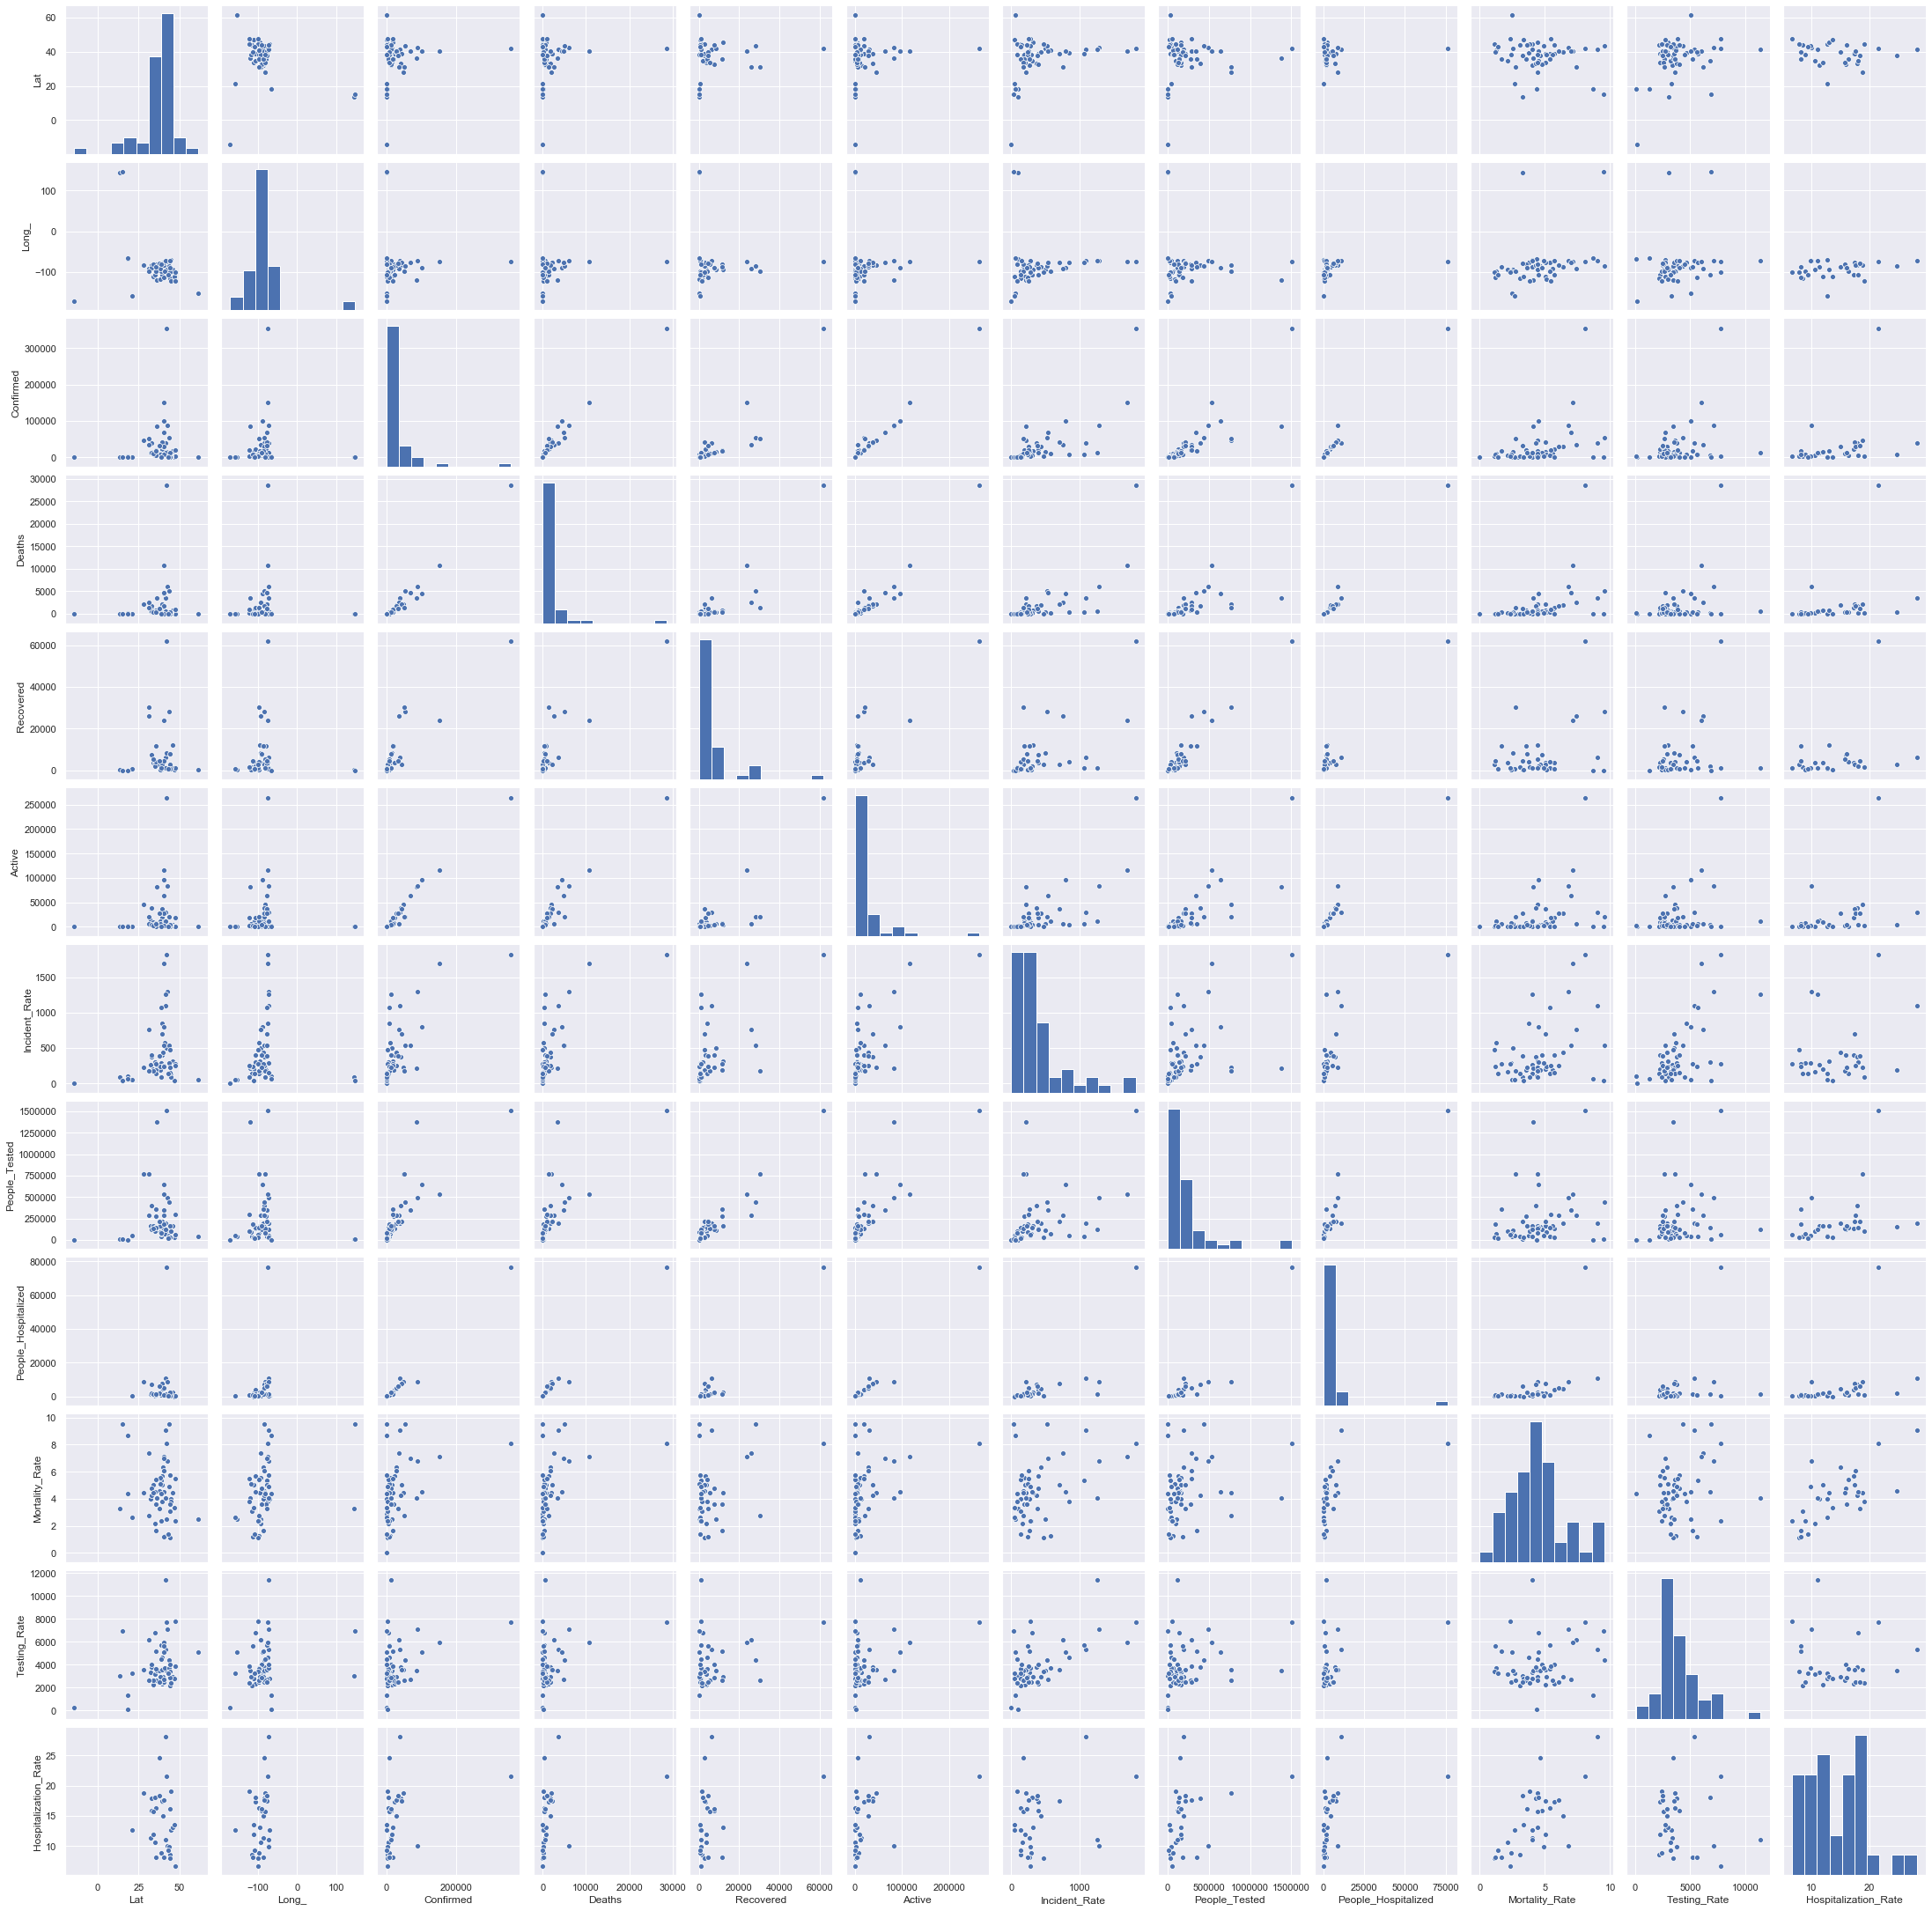

In [8]:
sb.pairplot(ds[numeric_col])

From above pairplot, we can see most of the columns are skewed, also number of deaths are somehow correlated with other columns.

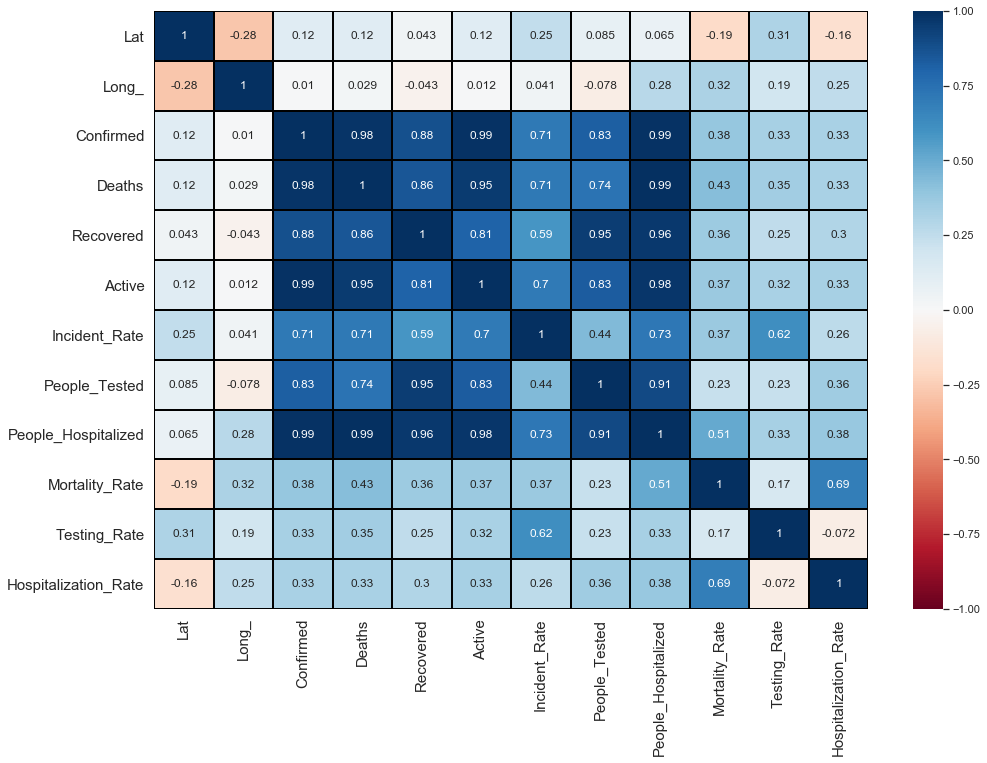

In [9]:
plt.figure(figsize = (16,11))
sb.heatmap(ds[numeric_col].corr(), vmin = -1, vmax = 1, center = 0, cmap = 'RdBu',
          linewidth =1, linecolor = 'black', annot = True)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

From above heatmap, we can infer that, almost all people how are hospitalized due to confirmed cases, eventually died on that day.

Correlation between  number of people who died at hospitals are more than that of who recovered from going to the hospitals.

People how are tested  covid positive, most probably go to the hospital, implying high correlation of  0.91 between these features.

Also, hospitalization rate is fairly correlated to mortality rate with value 0.69 and also with incident rate with value 0.73, implying hospitalizing does not ensure garanteed recovery from the disease.

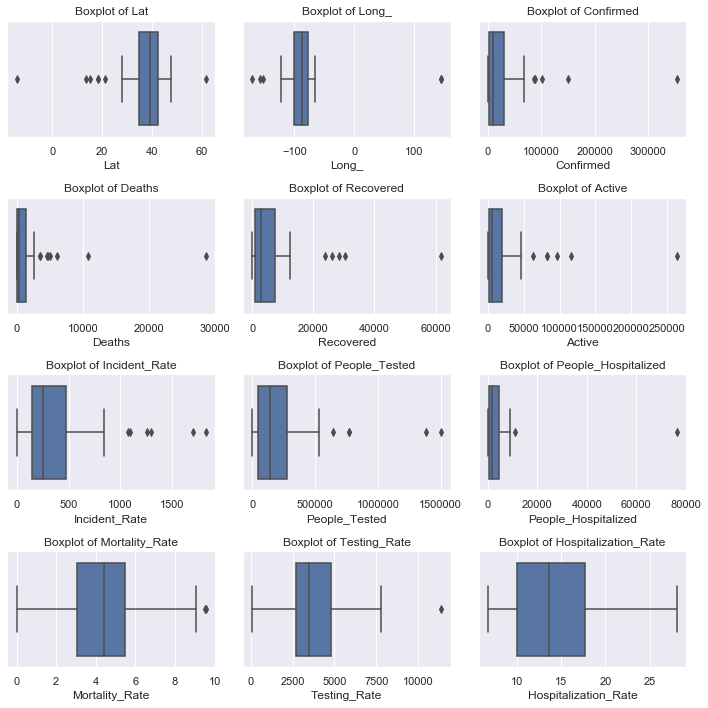

In [10]:
for i,col in enumerate(ds[numeric_col]):
    plt.subplot(4,3 ,i+1)
    sb.boxplot(ds[col])
    plt.title('Boxplot of ' + col)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

Here, we see many possible outliers that may effect in modelling small dataset,so we shall remove it using 3 std from mean method (using zscore) and also use robust scaling methods like robust scaler. 

In [11]:
state_wise_deaths = ds.groupby('Province_State').Deaths.agg(['sum']).sort_values('sum', ascending = False)

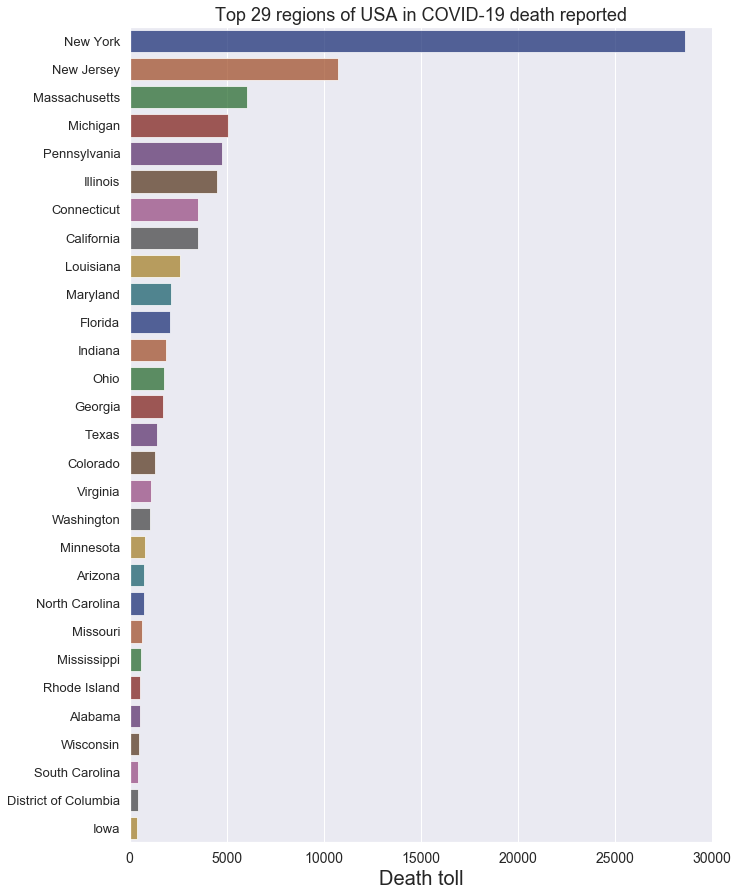

In [12]:
plt.figure(figsize = (23,15))


df = state_wise_deaths.reset_index()[['Province_State','sum']].head(29)

plt.subplot(1,2,1)
sb.barplot(x = 'sum' , y = 'Province_State' ,data = df
           ,palette= 'dark', alpha = 0.7)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 13)
plt.ylabel('')
plt.xlabel('Death toll' , fontsize = 20)
plt.title('Top 29 regions of USA in COVID-19 death reported', fontsize = 18 )
plt.show()

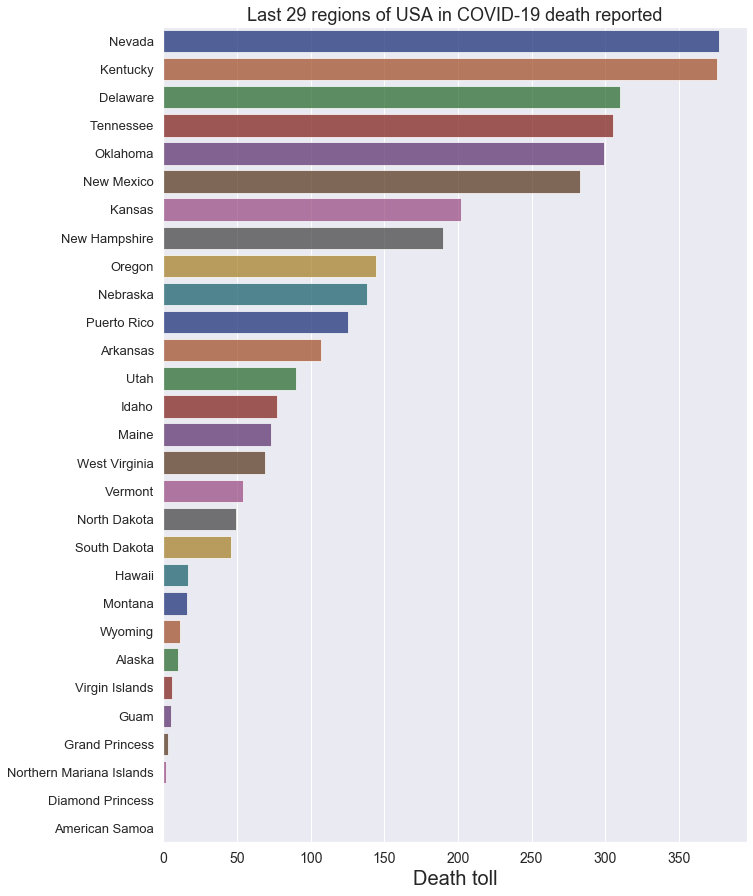

In [13]:
plt.figure(figsize = (23,15))


df = state_wise_deaths.reset_index()[['Province_State','sum']].tail(29)

plt.subplot(1,2,1)
sb.barplot(x = 'sum' , y = 'Province_State' ,data = df
           ,palette= 'dark', alpha = 0.7)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 13)
plt.ylabel('')
plt.xlabel('Death toll' , fontsize = 20)
plt.title('Last 29 regions of USA in COVID-19 death reported', fontsize = 18 )
plt.show()

From above bar charts, we see that New York City, being one of the most populated city and as well as other polulated regions has high death toll due to COVID-19. Particularly  New York City being the highest, in which death toll is almost triple the number in New Jersey. 

Also, less polulated regions of USA like Wyoming and  particularly islands have least Death Tolls.

In [14]:
ds[numeric_col].isnull().sum()

Lat                      2
Long_                    2
Confirmed                0
Deaths                   0
Recovered               16
Active                   0
Incident_Rate            2
People_Tested            2
People_Hospitalized     25
Mortality_Rate           1
Testing_Rate             2
Hospitalization_Rate    25
dtype: int64

In [15]:
# imputing missing columns with median of that column.
for col in numeric_col:
    if ds[col].isnull().sum() > 0:
        ds[col].fillna(ds[col].median(), inplace = True)

In [16]:
z = abs(zscore(ds[numeric_col]))

In [17]:
# here we are using z threshold as 3 to filter out outliers.
ds_new = ds[(z<3).all(axis =1)]

In [18]:
print('no. of outliers removed:',ds.shape[0] - ds_new.shape[0])

no. of outliers removed: 8


In [19]:
ds_new.drop(['Province_State'], 1, inplace = True)

In [20]:
# finding optimum random_state for the split of data into train-test.
r_state_score = []
for r_state in range(0,101):
    
    x_train, x_test, y_train, y_test = train_test_split(ds_new.drop('Deaths',1), ds_new['Deaths'],
                                                   test_size = 0.3, random_state = r_state)
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    score = r2_score(y_test,y_pred)
    r_state_score.append(score)

print('optimum r2_score:',max(r_state_score),'corresponds to random sate:',
      r_state_score.index(max(r_state_score)))    

optimum r2_score: 0.9614977618456475 corresponds to random sate: 94


In [21]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((35, 11), (15, 11), (35,), (15,))

In [22]:
# here we use optimum random_state as 94 as found in above step.
x_train, x_test, y_train, y_test = train_test_split(ds_new.drop('Deaths',1), ds_new['Deaths'],
                                                   test_size = 0.3, random_state = 94)

In [23]:
# robust scaling x_train and using statistics of x_train to transform x_test as well.
for col in x_train.columns:
    transformer = RobustScaler().fit(x_train[col].values.reshape(-1,1))
    x_train[col] = transformer.transform(x_train[col].values.reshape(-1,1))
    x_test[col] = transformer.transform(x_test[col].values.reshape(-1,1))

### Base Model Evaluation

model: RandomForestRegressor(random_state=42)
CV score:0.5394041694961895
score_std: 0.48619517679454666
----------
model: LinearRegression()
CV score:-2.102704414695991
score_std: 7.004285068870583
----------
model: SVR()
CV score:-0.8579013797090667
score_std: 0.9951590700962427
----------
model: AdaBoostRegressor(random_state=42)
CV score:-0.11642484415264964
score_std: 2.040037774226731
----------
model: GradientBoostingRegressor(random_state=42)
CV score:0.6947287099339616
score_std: 0.3532926066455318
----------
model: KNeighborsRegressor()
CV score:0.12398719345307777
score_std: 0.6860215364591351
----------
model: XGBRegressor(verbose=0)
CV score:-0.005043950805259901
score_std: 1.8601123789995584
----------
model: Lasso()
CV score:-1.9688024505967643
score_std: 6.794879726692436
----------
model: Ridge()
CV score:-1.612336511323774
score_std: 6.125869884266113
----------
model: ElasticNet()
CV score:0.08972652132033554
score_std: 1.5542791078501497
----------
model: DecisionTr

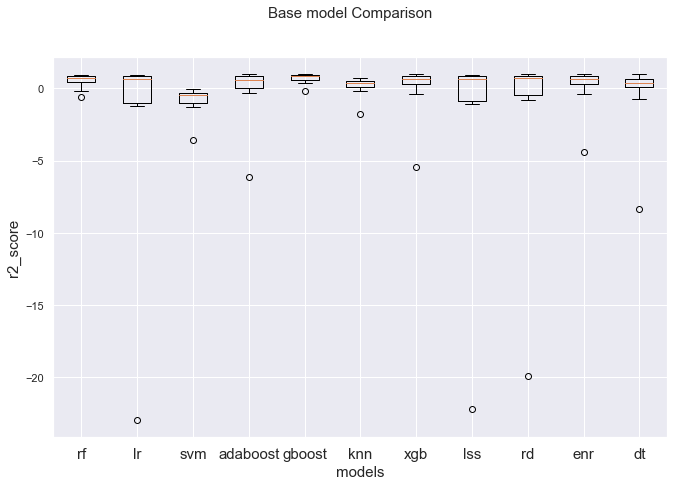

In [24]:
# initializing all models.
rf = RandomForestRegressor(random_state = 42)
svm = SVR()
lr = LinearRegression()
adaboost =  AdaBoostRegressor(random_state = 42)
gboost = GradientBoostingRegressor(random_state = 42)
knn = KNeighborsRegressor()
xgb = xgboost.XGBRegressor( verbose = 0)
lss = Lasso()
rd = Ridge()
enr = ElasticNet()
dt = DecisionTreeRegressor()


# computing cross-val-score for each model.
models = [rf, lr, svm, adaboost, gboost, knn, xgb, lss,rd,enr, dt]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = 10, scoring = 'r2', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 15)
plt.ylabel('r2_score', fontsize = 15)
plt.xlabel('models', fontsize = 15)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rf', 'lr','svm', 'adaboost', 'gboost', 'knn', 'xgb','lss','rd','enr','dt'],
                  fontsize = 15)
fig.set_size_inches(11,7)
plt.show() 

From above cross-val-scores, we see most models performed bad, and since the the dataset is small, this could probably be due to overfitting, so we shall select only relevant features for modelling.

In [25]:
# using GenericUnivariateSelect for feature selection
selector = GenericUnivariateSelect(f_regression, mode = 'percentile')
selector.fit(x_train, y_train)

GenericUnivariateSelect(score_func=<function f_regression at 0x000002034EB8D288>)

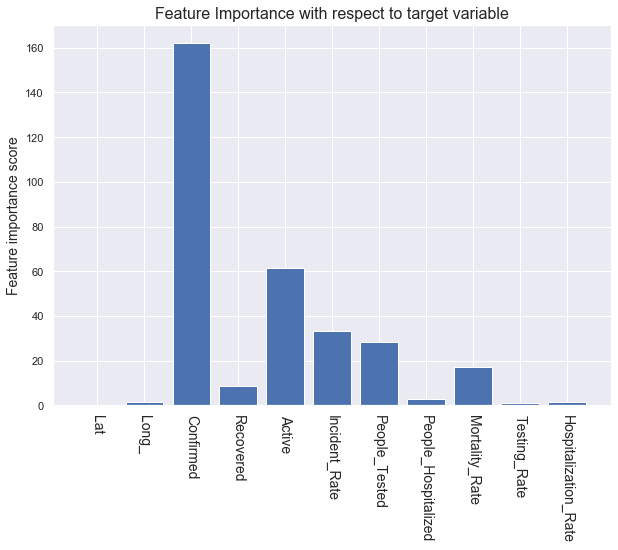

In [26]:
# plotting  the scores
plt.figure(figsize = (10,7))
plt.bar(x_train.columns, selector.scores_)
plt.xticks(rotation = -90, fontsize = 14)
plt.title('Feature Importance with respect to target variable', fontsize = 16)
plt.ylabel('Feature importance score', fontsize = 14)
plt.show()

On the of bases of above feature importance plot, we shall select features like Confirmed, Active, Incident Rate, People Tested and Mortality Rate for modelling, and drop those features whose importance is less significant.

In [27]:
# feature selecting
x_train_red = x_train[['Confirmed','Active','Incident_Rate','People_Tested',
                      'Mortality_Rate']]

x_test_red = x_test[['Confirmed','Active','Incident_Rate','People_Tested',
                       'Mortality_Rate']]

### Model Evaluation after Feature Selection

model: RandomForestRegressor(random_state=42)
CV score:0.5947562641685018
score_std: 0.4073897085396359
----------
model: LinearRegression()
CV score:-0.718580739049118
score_std: 3.324806313553
----------
model: SVR()
CV score:-0.8528499147309893
score_std: 0.9930152177234594
----------
model: AdaBoostRegressor(random_state=42)
CV score:-0.07887711421887222
score_std: 2.038745766317619
----------
model: GradientBoostingRegressor(random_state=42)
CV score:0.5858493559442739
score_std: 0.4889748169598173
----------
model: KNeighborsRegressor()
CV score:0.6747675445288939
score_std: 0.26483005961888123
----------
model: XGBRegressor(verbose=0)
CV score:-0.1330373017672835
score_std: 2.3181737662257262
----------
model: Lasso()
CV score:-0.7041669387907353
score_std: 3.296253155128698
----------
model: Ridge()
CV score:-0.5080748201802492
score_std: 2.9109488913485793
----------
model: ElasticNet()
CV score:0.40440875993710906
score_std: 0.7927244894238324
----------
model: DecisionTreeRe

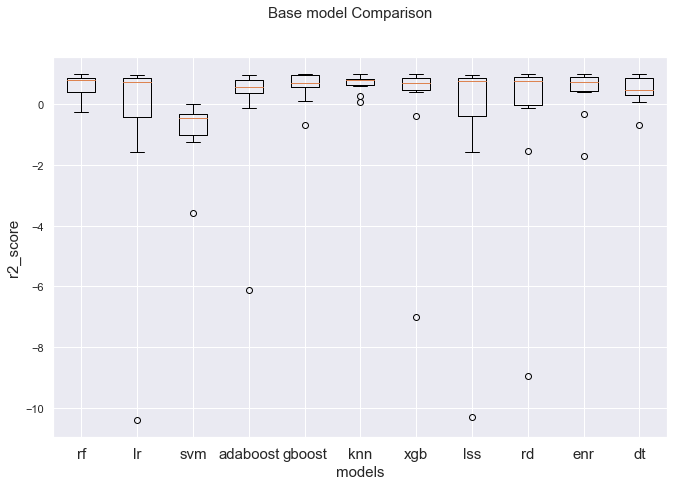

In [28]:
# initializing all models.
rf = RandomForestRegressor(random_state = 42)
svm = SVR()
lr = LinearRegression()
adaboost =  AdaBoostRegressor(random_state = 42)
gboost = GradientBoostingRegressor(random_state = 42)
knn = KNeighborsRegressor()
xgb = xgboost.XGBRegressor( verbose = 0)
lss = Lasso()
rd = Ridge()
enr = ElasticNet()
dt = DecisionTreeRegressor()


# computing cross-val-score for each model.
models = [rf, lr, svm, adaboost, gboost, knn, xgb, lss,rd,enr, dt]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train_red, y_train, cv = 10, scoring = 'r2', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 15)
plt.ylabel('r2_score', fontsize = 15)
plt.xlabel('models', fontsize = 15)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rf', 'lr','svm', 'adaboost', 'gboost', 'knn', 'xgb','lss','rd','enr','dt'],
                  fontsize = 15)
fig.set_size_inches(11,7)
plt.show() 

From above boxplot of cross-val-score, we shall only choose those models with positive r2_score.

### Hyper-parameter tuning

In [29]:
param_knn = dict(n_neighbors = np.arange(1,20,1), weights = ['uniform','distance'],
                algorithm = ['auto', 'all_tree', 'kd_tree', 'brute'])

param_enr = dict(alpha = np.arange(0.05,2, 0.05), l1_ratio = np.arange(0.05,1, 0.01),
                 normalize = [True, False], selection = ['cyclic', 'random'])

param_gboost =  dict(
    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
    max_depth = [ 3, 4, 5, 6, 8],
    n_estimators = [100, 150, 200],
    min_samples_split = [1,2,3])


param_rf = dict(n_estimators = [10,15,20,25,30],
                max_depth = [3,4,5,6,7,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [41,42,43])

In [30]:
model_param_list = [(knn, param_knn), (gboost,param_gboost), (enr,param_enr), (rf, param_rf)]

In [31]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    grid = GridSearchCV(model, param, cv = 10, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
    
    grid.fit(x_train_red, y_train.values.ravel())
    best_cvscore = grid.best_score_
    best_param = grid.best_params_
    best_estimator = grid.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
print('best_estimators:',best_estimator_list)

model: KNeighborsRegressor()
best_cvscore: -459.2936434430927
best_param: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}


model: GradientBoostingRegressor(random_state=42)
best_cvscore: -409.6745399952753
best_param: {'learning_rate': 0.15, 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 200}


model: ElasticNet()
best_cvscore: -467.41475016389234
best_param: {'alpha': 0.7000000000000001, 'l1_ratio': 0.1, 'normalize': False, 'selection': 'random'}


model: RandomForestRegressor(random_state=42)
best_cvscore: -398.56284301320954
best_param: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 20, 'random_state': 42}


best_estimators: [KNeighborsRegressor(n_neighbors=3, weights='distance'), GradientBoostingRegressor(learning_rate=0.15, max_depth=5, min_samples_split=3,
                          n_estimators=200, random_state=42), ElasticNet(alpha=0.7000000000000001, l1_ratio=0.1, selection='random'), RandomForestRegressor(max_depth=5, 

### Testing

In [32]:
# testing for train data

print('*******TRAIN RESULTS*******')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_train_red)
    score = r2_score(y_train, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_train, y_pred, squared = False))
    print('-------------------------------------------')

*******TRAIN RESULTS*******


model KNeighborsRegressor(n_neighbors=3, weights='distance')
accuracy (r2_score): 100.0 %
root_mean_squared_error: 0.0
-------------------------------------------
model GradientBoostingRegressor(learning_rate=0.15, max_depth=5, min_samples_split=3,
                          n_estimators=200, random_state=42)
accuracy (r2_score): 100.0 %
root_mean_squared_error: 6.549638470530024e-07
-------------------------------------------
model ElasticNet(alpha=0.7000000000000001, l1_ratio=0.1, selection='random')
accuracy (r2_score): 85.97 %
root_mean_squared_error: 506.964186995757
-------------------------------------------
model RandomForestRegressor(max_depth=5, min_samples_split=3, n_estimators=20,
                      random_state=42)
accuracy (r2_score): 97.62 %
root_mean_squared_error: 208.99792197262363
-------------------------------------------


In [33]:
#testing for test data
print('*******TEST RESULTS*******')
print('\n')
for model in best_estimator_list:
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_test_red)
    score = r2_score(y_test, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_test, y_pred, squared = False))
    print('-------------------------------------------')

*******TEST RESULTS*******


model KNeighborsRegressor(n_neighbors=3, weights='distance')
accuracy (r2_score): 91.56 %
root_mean_squared_error: 435.38261085967474
-------------------------------------------
model GradientBoostingRegressor(learning_rate=0.15, max_depth=5, min_samples_split=3,
                          n_estimators=200, random_state=42)
accuracy (r2_score): 43.52 %
root_mean_squared_error: 1126.412984029199
-------------------------------------------
model ElasticNet(alpha=0.7000000000000001, l1_ratio=0.1, selection='random')
accuracy (r2_score): 87.86 %
root_mean_squared_error: 522.2821043861564
-------------------------------------------
model RandomForestRegressor(max_depth=5, min_samples_split=3, n_estimators=20,
                      random_state=42)
accuracy (r2_score): 49.01 %
root_mean_squared_error: 1070.3120819434284
-------------------------------------------


From above train and test results, we see that KNeighborsRegressor model performed the best in test data, where it has the  lowest root mean squared error and highest r2 score compared to other models, so we shall choose KNN as our regression model for this project. 

In [34]:
# selecting the final model as KNeighborsRegressor.
selected_model =  KNeighborsRegressor(n_neighbors=3, weights='distance')
selected_model.fit(x_train_red, y_train)

y_pred = selected_model.predict(x_test_red)

In [35]:
test_df = pd.DataFrame({'Actual Deaths':y_test.values,'Predicted Deaths':y_pred})

In [36]:
# rounding the death toll, as it can only be integers.
test_rounded_df = test_df.round()

In [37]:
test_rounded_df.to_csv('covid_deaths_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


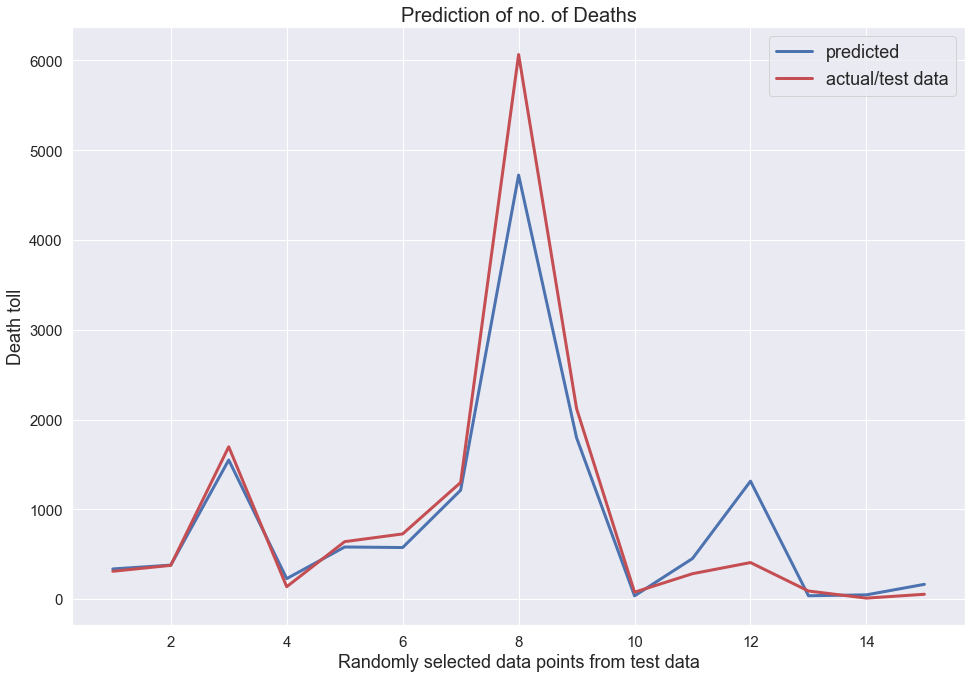

In [38]:
fig = plt.figure(figsize = (16,11))
ax = fig.add_subplot(111)
ax.plot(np.arange(1,16,1),y_pred, 'b-', linewidth = 3)
ax.plot(np.arange(1,16,1), y_test, 'r-', linewidth = 3)
plt.legend(['predicted','actual/test data'],prop={'size': 18})
plt.xticks( fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Randomly selected data points from test data', fontsize= 18)
plt.ylabel('Death toll', fontsize= 18)
plt.title('Prediction of no. of Deaths', fontsize= 20)
plt.show()

In [39]:
# Saving the final model as KNeighborsRegressor.
import joblib

joblib.dump(selected_model, 'covid_deaths_pred.obj')
print('Model successfully saved.')

Model successfully saved.
